# Micro Elbow Fitting assembly defect detection in manufacturing process.

## What do elbows do?
In addition to the flex point for your arm, elbows are industrial fittings that change the direction of piping. The connections allow you to reroute regularly threaded pipes to turn corners or fit in limited space without the expense of buying a pipe bender.

Standard elbows come in a few different angles – 45°, 90°, and, although they are less common, 22.5° angles – and can be made of the same materials as any other piping. We have a wide selection of elbows and other fittings in stainless steel 304 or 316.

[More](https://www.directmaterial.com/fittings-what-is-an-elbow)

# Problem statement
When manufacturing micro elbow fittings that used in aeronautical and medical equipment quality of the assembly is an utmost concern. Given the size of the fitting is less than 10mm x 10mm, the defect detection process is painstaking. The process has to be automated. 

#Objective 
To build a defect detection system using deep learning models.

#Build summary
Using ImageNet VGG16 weights and transfer learning a model is built on TensorFlow framework.
 


In [1]:
# Select tenforflow version
%tensorflow_version 2.x

TensorFlow 2.x selected.


## Download the dataset

In [2]:

!wget -qq https://www.dropbox.com/sh/qdefq82800k4pbu/AADNS_0BTtUp_musb4IPSz65a?dl=0
!unzip -qq AADNS_0BTtUp_musb4IPSz65a?dl=0
!unzip -qq eqp_img.zip
!rm AADNS_0BTtUp_musb4IPSz65a?dl=0
!rm -r eqp_img.zip
!mkdir saved_model
!ls

mapname:  conversion of  failed

1 archive had fatal errors.
sample_data  saved_model  up


In [3]:
!ls up/

test  train  valid


In [4]:
!ls up/train

ok  rej


In [5]:
!ls up/valid

ok  rej


In [6]:
!ls up/test

1.jpg  2.jpg  3.jpg  4.jpg  5.jpg  6.jpg  7.jpg


## Imports

In [7]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt

import os, json
from glob import glob

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.models import Model,load_model,Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, Callback,EarlyStopping
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten, Input
from tensorflow.keras import backend as K
import pandas as pd
import numpy as np
from IPython.display import Image

Using TensorFlow backend.


In [8]:
#Check GPU
gpu_name = tf.test.gpu_device_name()
if gpu_name != '/device:GPU:0':
  print('GPU not found')
print('{} GPU Found'.format(gpu_name))

/device:GPU:0 GPU Found


In [9]:
!nvidia-smi

Wed Feb 26 04:03:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    23W /  75W |    115MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [10]:
#Check Tf Keras version
print(tf.keras.__version__)
print(tf.__version__)

2.2.4-tf
2.1.0


## Converting image files to tf data format



In [0]:
def get_file_path():
  data = []
  for root, dirs, files in os.walk(train_path, topdown=True):
    for name in files:
      if '.jpg' not in name:
        continue
      filename = os.path.abspath(os.path.join(root, name))
      class_name = os.path.basename(root)
      data.append((filename, class_name))

  df = pd.DataFrame(data, columns=['filename', 'class_name'])

  df['class_name'] = df['class_name'].astype('category')
  df['class'] = df['class_name'].cat.codes

  #shuffle
  df = df.sample(frac=1).reset_index(drop=True)
  
  print(len(df))
  df.dtypes
  return df

In [12]:
path = "./up/"
train_path = "./up/train/"
validation_path = "./up/valid/"
df=get_file_path()
df.head(10)

42


,filename,class_name,class
0,/content/up/train/ok/ok.15-1.jpg,ok,0
1,/content/up/train/rej/rej.20-1.jpg,rej,1
2,/content/up/train/rej/rej.17-1.jpg,rej,1
3,/content/up/train/ok/ok.20-1.jpg,ok,0
4,/content/up/train/ok/ok.4-1.jpg,ok,0
5,/content/up/train/ok/ok.21-1.jpg,ok,0
6,/content/up/train/rej/rej.4-1.jpg,rej,1
7,/content/up/train/rej/rej.7-1.jpg,rej,1
8,/content/up/train/ok/ok.1-1.jpg,ok,0
9,/content/up/train/rej/rej.15-1.jpg,rej,1


## Sample of a good product

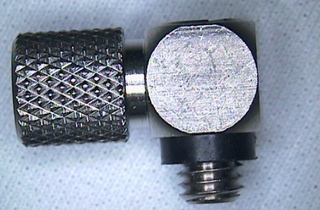

In [13]:
Image('/content/up/train/ok/ok.2-1.jpg')

## Sample of a reject product

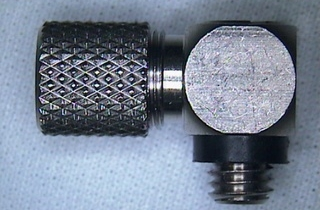

In [14]:
Image('/content/up/train/rej/rej.3-1.jpg')

## Image augmentation

In [0]:
#function to image augmentation
def image_aug(imgpath_df,savepath,prefix):
  datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, 
  height_shift_range=0.1,shear_range=0.15, 
  zoom_range=0.1,channel_shift_range = 10, horizontal_flip=True)
  from keras.preprocessing.image import load_img
  for i in imgpath:
    img = np.expand_dims(load_img(i), 0)
    for x, val in zip(datagen.flow(img,
          save_to_dir=save_here,     #set where to save
           save_prefix=prefix, #set prefix
          save_format='jpg'),range(10)) :     # define a range because we want 10 augmented images
      pass

In [0]:
imgpath=df[df['class_name']=='ok']['filename']
save_here = './up/train/ok'
prefix='ok'
image_aug(imgpath_df=imgpath,savepath=save_here,prefix=prefix)

In [0]:
imgpath=df[df['class_name']=='rej']['filename']
save_here = './up/train/rej'
prefix='rej'
image_aug(imgpath_df=imgpath,savepath=save_here,prefix=prefix)

In [18]:
# update dataframe with augmented imges
df=get_file_path()

501


## Split training and validation data (90:10)

In [0]:

# Split into train and validation sets
train_set_percentage = .9


df = df[:int(len(df)*train_set_percentage)]
df_val = df[int(len(df)*train_set_percentage):]

# shuffle 
df = df.sample(frac=1).reset_index(drop=True)
df_val = df_val.sample(frac=1).reset_index(drop=True)

In [20]:
df.shape

(450, 3)

In [21]:
df_val.shape

(45, 3)

## Make the pipeline for loading and resizing the images

In [0]:
# Reads an image from a file, decodes it into a tensor, and resizes it
# to a fixed shape.
img_width, img_height = 224,224
num_classes = 2
batch_size = 32

def _parse_function(filename, label):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string,channels=3)
  image_resized = tf.image.resize(image_decoded, [img_width, img_height])
  image_resized = tf.ensure_shape(image_resized ,shape=(img_width, img_height,3))
  label = tf.one_hot(label, num_classes)
  return image_resized, label


## Assembling the Data pipeline using tf.data

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df['filename'].values, tf.string),
                                                    tf.cast(df['class'].values, tf.int32) ))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.shuffle(5000)
train_dataset = train_dataset.repeat() #if get to the end start again when picking batch
train_dataset = train_dataset.batch(batch_size, drop_remainder=True) #only give me the batch size of images less than that throw away

In [0]:
valid_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_val['filename'].values, tf.string),
                                                    tf.cast(df_val['class'].values, tf.int32) ))
valid_dataset = valid_dataset.map(_parse_function)
valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.batch(batch_size, drop_remainder=True)

## Download the VGG16 network weights for transfer learning

In [25]:
# download pre-trained model weights
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3),pooling=None) #include_top=False to chop off flatten model


58892288/58889256 [==============================] - 2s 0us/step


In [26]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Add a global spatial average pooling layer

In [0]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)

predictions = Dense(2, activation='softmax')(x)


In [0]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

## Freeze all convolutional VGG16 layers



In [29]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional VGG16 layers
for layer in base_model.layers:
    print(layer.name)
    layer.trainable = False


input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


## Un-Freeze global spatial average pooling layer and two dense layers

In [30]:
for layer in model.layers:
    print(layer.name,' Trainable =',layer.trainable)

input_1  Trainable = False
block1_conv1  Trainable = False
block1_conv2  Trainable = False
block1_pool  Trainable = False
block2_conv1  Trainable = False
block2_conv2  Trainable = False
block2_pool  Trainable = False
block3_conv1  Trainable = False
block3_conv2  Trainable = False
block3_conv3  Trainable = False
block3_pool  Trainable = False
block4_conv1  Trainable = False
block4_conv2  Trainable = False
block4_conv3  Trainable = False
block4_pool  Trainable = False
block5_conv1  Trainable = False
block5_conv2  Trainable = False
block5_conv3  Trainable = False
block5_pool  Trainable = False
global_average_pooling2d  Trainable = True
dense  Trainable = True
dense_1  Trainable = True


In [31]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Complie model

In [0]:
opt = tf.keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

In [33]:
train_steps = int(len(df)/32) #total trains set / batch_size
val_steps = int(len(df_val)/32)
epochs = 50

print('train steps:',train_steps)
print('val steps:',val_steps)
print('Epochs:',epochs)

train steps: 14
val steps: 1
Epochs: 50


## Early stopping callback

In [0]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

## Best model saving checkpoint callback

In [0]:
checkpoint = ModelCheckpoint('./saved_model/best_model_weights.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

## Train model

In [36]:
### Train the model with validation 
history = model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,callbacks=[es,checkpoint],
                   validation_data = valid_dataset,
                   validation_steps = val_steps)

Train for 14 steps, validate for 1 steps
Epoch 1/50
13/14 [==========================>...] - ETA: 0s - loss: 1.6734 - accuracy: 0.7332
Epoch 00001: val_accuracy improved from -inf to 0.96875, saving model to ./saved_model/best_model_weights.hdf5
14/14 [==============================] - 12s 827ms/step - loss: 1.5607 - accuracy: 0.7500 - val_loss: 0.0661 - val_accuracy: 0.9688
Epoch 2/50
13/14 [==========================>...] - ETA: 0s - loss: 0.0619 - accuracy: 0.9784
Epoch 00002: val_accuracy improved from 0.96875 to 1.00000, saving model to ./saved_model/best_model_weights.hdf5
14/14 [==============================] - 3s 209ms/step - loss: 0.0588 - accuracy: 0.9799 - val_loss: 0.0204 - val_accuracy: 1.0000
Epoch 3/50
13/14 [==========================>...] - ETA: 0s - loss: 0.0130 - accuracy: 0.9976
Epoch 00003: val_accuracy did not improve from 1.00000
14/14 [==============================] - 3s 194ms/step - loss: 0.0141 - accuracy: 0.9978 - val_loss: 0.0078 - val_accuracy: 1.0000
Epo

In [37]:
# Check saved model
!ls saved_model/

best_model_weights.hdf5


## Check matrics

In [38]:
metrics = model.evaluate(valid_dataset,
                   steps = val_steps)
print("model accuracy:",metrics[1])

1/1 [==============================] - 0s 232ms/step - loss: 1.0762e-04 - accuracy: 1.0000
model accuracy: 1.0


## Plot loss and accuracy curves

In [0]:
# Function to plot loss and accuracy curves
def plot_curves():
  # Get training and test loss histories
  training_loss = history.history['loss']
  test_loss = history.history['val_loss']
  training_acc = history.history['accuracy']
  test_acc = history.history['val_accuracy']
  # Create count of the number of epochs
  epoch_count = range(1, len(training_loss) + 1)

  # Visualize loss history
  plt.plot(epoch_count, training_loss, 'r--')
  plt.plot(epoch_count, test_loss, 'b-')
  plt.legend(['Training Loss', 'Test Loss'])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show();
  # Visualize accuracy history
  plt.plot(epoch_count, training_acc, 'r--')
  plt.plot(epoch_count, test_acc, 'b-')
  plt.legend(['Training accuracy', 'Test accuracy'])
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.show();

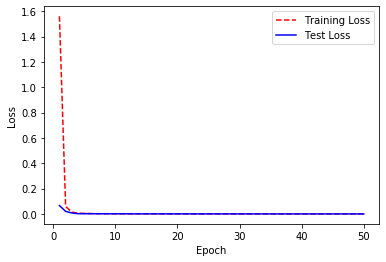

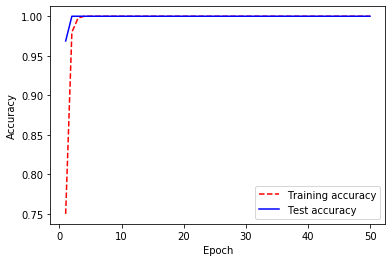

In [40]:
plot_curves()

## Prediction using test images

In [0]:
#Function for prediction
def predict(image_path,image_check):
  img_path = os.path.join(image_path, image_check)
  print(img_path)
  img = image.load_img(img_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  preds = model.predict(x)
  print('Predicted:', preds)
  result= preds[0][0]
  if result< preds[0][1]:
     print("REJECT Product")
  else:
     print("GOOD Product")
  

./up/test/1.jpg
Predicted: [[0.77042204 0.22957797]]
GOOD Product


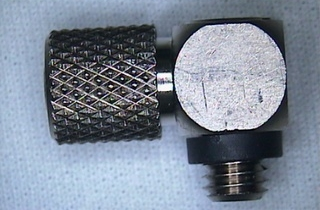

In [42]:
image_path = './up/test/'
image_check = '1.jpg'
predict(image_path,image_check)
Image(image_path+image_check)


./up/test/6.jpg
Predicted: [[3.236872e-09 1.000000e+00]]
REJECT Product


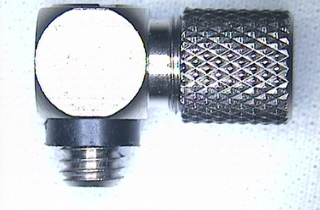

In [43]:
image_path = './up/test/'
image_check = '6.jpg'
predict(image_path,image_check)
Image(image_path+image_check)

# Conclusion
Model was able to achieve valuation accuracy of 100% with training and valuation loss almost near to 0. Able to predict hardest to find rejects like barb connector screw being not fully engaged (example above). Overall, satisfied of the performance with the limited number of image data used; but in future heavy image augmentation maybe reduced or replaced by more image data.